# Recommender Case

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.preprocessing import LabelEncoder, StandardScaler
import hdbscan
from sklearn.cluster import KMeans
import logging
import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

In [2]:
# Load the purchase history data into a DataFrame
df_product = pd.read_excel('customer_sales.xlsx', sheet_name='product')
df_customer = pd.read_excel('customer_sales.xlsx', sheet_name='customer')
df_sales = pd.read_excel('customer_sales.xlsx', sheet_name='sales')

# Understanding the dataset

In [3]:
df_sales.head()

,ID_Product,ID_Customer,Sales,Revenue,Data
0,it002879,cr000347,1.0,102.0,2021-06-15
1,it002879,cr000751,3.0,402.0,2022-09-22
2,it004560,cr000371,1.0,467.0,2022-10-05
3,it004560,cr000371,2.0,920.0,2022-10-31
4,it004135,cr000131,1.0,262.0,2021-02-25


# Data preprocessing

In [4]:
df_sales['OrdFreqPerMonth'] = ((df_sales.groupby('ID_Customer')['Data'].transform('max') \
                                    -df_sales.groupby('ID_Customer')['Data'].transform('min')).dt.days/30).astype(int)

In [5]:
# Preparation customers table for colaborative filtering
customers = ((df_sales.groupby(['ID_Customer']).agg({'Revenue': 'sum', 'OrdFreqPerMonth' : 'mean'})) \
             .join(df_customer.set_index('ID_Customer'), on='ID_Customer', how="left"))
customers = customers[['Business Area', 'Region', 'Revenue', 'OrdFreqPerMonth']]

In [6]:
# Apply LabelEncoder to each categorical column
le= LabelEncoder()
for col in ['Business Area', 'Region']:
    customers[col] = le.fit_transform(customers[col])

In [7]:
# Data scaling
customers[['Business Area', 'Region','Revenue','OrdFreqPerMonth']] = \
                        StandardScaler().fit_transform(customers[['Business Area', 'Region','Revenue','OrdFreqPerMonth']])

In [8]:
customers.head()

,Business Area,Region,Revenue,OrdFreqPerMonth
ID_Customer,,,,
cr000122,-0.857779,0.288102,-0.376376,-0.129301
cr000123,0.791218,0.449255,-0.466166,-1.437485
cr000124,1.615716,0.288102,-0.481662,-1.556410
cr000125,-0.857779,-1.968034,-0.059135,1.297809
cr000126,0.791218,0.288102,-0.331118,0.227477


In [9]:
customers.shape

(768, 4)

# Finding clusters for colaborative filtering model

In [10]:
def try_different_clusters(K, data):

    cluster_values = list(range(1, K+1))
    inertias=[]

    for c in cluster_values:
        model = KMeans(n_clusters = c, init='k-means++', n_init='auto', max_iter=400, random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)

    return inertias

In [11]:
outputs = try_different_clusters(10, customers)
distances = pd.DataFrame({"clusters": list(range(1, 11)), 'sum of squared distances ' : outputs})

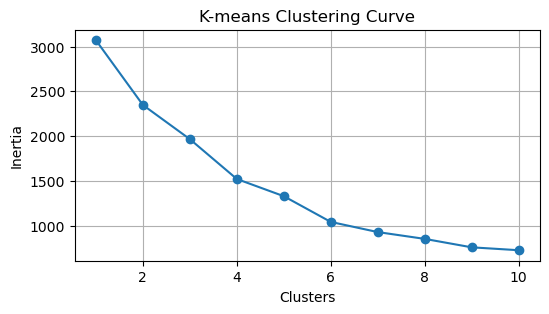

In [12]:
plt.figure(figsize=(6, 3),dpi=100)
plt.plot(range(1, 11), outputs, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering Curve')

plt.grid(True)
plt.show()

In [13]:
# Find optimal number of clusters
best_score = 0

for min_cluster_size in [2,3,4,5,6,7,8,9,10]:
    for min_samples in [3,5,10,30,50]:
        for cluster_selection_method in ['eom','leaf']:
            for metric in ['euclidean']:
                # for each combination of parameters of hdbscan
                hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,min_samples=min_samples,
                                      cluster_selection_method=cluster_selection_method, metric=metric, 
                                      gen_min_span_tree=True).fit(customers)
                # DBCV score
                score = hdb.relative_validity_
                # if we got a better DBCV, store it and the parameters
                if score > best_score:
                    best_score = score
                    best_parameters = {'min_cluster_size': min_cluster_size, 
                               ' min_samples':  min_samples, 'cluster_selection_method': cluster_selection_method,
                              'metric': metric}

print("Best DBCV score: {:.3f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best DBCV score: 0.228
Best parameters: {'min_cluster_size': 7, ' min_samples': 5, 'cluster_selection_method': 'eom', 'metric': 'euclidean'}


In [14]:
n_clusters_ = best_parameters['min_cluster_size']

kmeans_model_new = KMeans(n_clusters = n_clusters_, n_init=10, init='k-means++', max_iter=400, random_state=42)

In [15]:
customers['Cluster'] = kmeans_model_new.fit_predict(customers)

In [16]:
customers.head()

,Business Area,Region,Revenue,OrdFreqPerMonth,Cluster
ID_Customer,,,,,
cr000122,-0.857779,0.288102,-0.376376,-0.129301,1
cr000123,0.791218,0.449255,-0.466166,-1.437485,3
cr000124,1.615716,0.288102,-0.481662,-1.556410,3
cr000125,-0.857779,-1.968034,-0.059135,1.297809,0
cr000126,0.791218,0.288102,-0.331118,0.227477,6


# Data for recommender preparation

In [17]:
# Dict for drop down periods list

In [18]:
periods = {"1 Month": 30,"3 Months": 90,"6 Months": 180,"12 Months": 365,"24 Months": 730}

In [19]:
# Define dropdown widgets
dropdown1 = widgets.Dropdown(
    options=customers.index,
    description='Customer:'
)

dropdown2 = widgets.Dropdown(
    options=list(periods.keys()),
    description='Period:'
)

# Define button widget
button = widgets.Button(description="Accept Selection")

# Define output widget
output_result = widgets.Output()

# Global variable to store the result
result_data = None

# Define function to handle button click event
def on_button_click(b):
    global result_data
    selected_value_dropdown1 = dropdown1.value
    selected_value_dropdown2 = dropdown2.value
    
    # Construct the result dictionary
    result = {
        'Customer': selected_value_dropdown1,
        'Period': selected_value_dropdown2
    }
    
    # Store the result data in the global variable
    result_data = result
    
    # Display the result dictionary along with selected options
    with output_result:
        output_result.clear_output()
        print("Selected Values:")
        print("Customer:", selected_value_dropdown1)
        print("Period  :", selected_value_dropdown2)

# Link button click event to the function
button.on_click(on_button_click)

# Display the widgets
print("Please select options and accept it:")
display(dropdown1)
display(dropdown2)
display(button)
display(output_result)

Please select options and accept it:


Dropdown(description='Customer:', options=('cr000122', 'cr000123', 'cr000124', 'cr000125', 'cr000126', 'cr0001…

Dropdown(description='Period:', options=('1 Month', '3 Months', '6 Months', '12 Months', '24 Months'), value='…

Button(description='Accept Selection', style=ButtonStyle())

Output()

In [20]:
#Preparation for filtering table by customer and period after selection

In [21]:
selected_customer = list(result_data.values())[0]

In [22]:
selected_period = list(result_data.values())[1]

max_date = df_sales['Data'].unique().max()
min_date = max_date - pd.Timedelta(days=periods[selected_period])

In [23]:
#Retrieve client information including cluster label
customer_info = customers[customers.index == selected_customer]
customer_cluster = customer_info['Cluster'].iloc[0]

#Filter sales data based on selected client and cluster
cluster_customers = customers[(customers['Cluster'] == customer_cluster)].reset_index()

In [24]:
cluster_customers.head()

,ID_Customer,Business Area,Region,Revenue,OrdFreqPerMonth,Cluster
0,cr000126,0.791218,0.288102,-0.331118,0.227477,6
1,cr000128,0.791218,0.288102,0.592305,0.703180,6
2,cr000131,0.791218,-0.678813,-0.204808,0.703180,6
3,cr000141,0.791218,0.771560,-0.088694,0.227477,6
4,cr000164,0.791218,1.093865,-0.425781,0.346402,6


In [25]:
#Filtering table by customers
df_sales_cf = df_sales.join(cluster_customers.set_index('ID_Customer')['Cluster'], on='ID_Customer', how='right')

In [26]:
#Filtering table by customers + period
df_sales_cf = df_sales_cf[(df_sales_cf['Data'] >= min_date)]

In [27]:
df_sales_cf.head()

,ID_Product,ID_Customer,Sales,Revenue,Data,OrdFreqPerMonth,Cluster
22613,it003992,cr000128,1.0,242.0,2022-08-19,19,6
23051,it002398,cr000128,-1.0,-1610.0,2022-09-21,19,6
23136,it003136,cr000128,1.0,2457.0,2022-10-21,19,6
25098,it006847,cr000128,1.0,3034.0,2022-09-09,19,6
25115,it004701,cr000128,1.0,2693.0,2022-10-22,19,6


# Model evaluation

In [28]:
# Count the number of purchases for each user and product combination
purchase_counts = df_sales_cf.groupby(['ID_Customer', 'ID_Product']).size().unstack(fill_value=0)

In [29]:
purchase_counts.head()

ID_Product,it002111,it002114,it002115,it002117,it002122,it002123,it002128,it002136,it002143,it002152,...,it009161,it009168,it009169,it009170,it009176,it009181,it009188,it009189,it009201,it009203
ID_Customer,,,,,,,,,,,,,,,,,,,,,
cr000128,0,0,0,0,0,2,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
cr000131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cr000165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
cr000179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cr000184,0,1,0,0,2,0,0,0,0,1,...,0,0,0,0,4,0,0,0,0,0


In [30]:
# Convert the purchase counts to a sparse matrix
sparse_purchase_counts = sparse.csr_matrix(purchase_counts)

In [31]:
sparse_purchase_counts

<98x1136 sparse matrix of type '<class 'numpy.int64'>'
	with 2516 stored elements in Compressed Sparse Row format>

In [32]:
# Compute the cosine similarity matrix between the products
cosine_similarities = cosine_similarity(sparse_purchase_counts.T)

In [33]:
cosine_similarities

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.4472136,
        0.4472136],
       [0.       , 0.       , 0.       , ..., 0.4472136, 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.4472136, 0.       ,
        1.       ]])

# Model prediction

In [34]:
# Define a function to recommend items for a user based on their purchase history
def recommend_items(user_id, n=5):
    # Get the user's purchase history
    user_history = sparse_purchase_counts[purchase_counts.index.get_loc(user_id)].toarray().flatten()

    # Compute the average cosine similarity between the user's purchased items and all other items
    similarities = cosine_similarities.dot(user_history)

    # Get the indices of the user's purchased items
    purchased_indices = np.where(user_history > 0)[0]

    # Set the similarity scores for purchased items to 0
    similarities[purchased_indices] = 0

    # Sort the items by similarity score and return the top n items
    recommended_indices = np.argsort(similarities)[::-1][:n]
    recommended_items = list(purchase_counts.columns[recommended_indices])
    
    # Remove the items that the user has already purchased
    purchased_items = list(purchase_counts.columns[purchase_counts.loc[user_id] > 0])
    recommended_items = [item for item in recommended_items if item not in purchased_items]

    return recommended_items

# Result

In [35]:
try:
    print(f'For customer #{selected_customer} recommended items is', recommend_items(selected_customer))
    print('\n',pd.DataFrame(recommend_items(selected_customer), columns=['ID_Product']) \
          .join(df_product.set_index('ID_Product'), on='ID_Product', how='left')[['ID_Product', 'Product Full Name']])
except KeyError as e:
    print(f"Error occurred during to not enough data in selected period of customer #{selected_customer} for research.")

For customer #cr000242 recommended items is ['it005636', 'it005638', 'it002203', 'it005563', 'it007271']

   ID_Product                                  Product Full Name
0   it005636  Autoglass - Mercedes W901-905 Sprinter (высоки...
1   it005638             Autoglass - Renault/Dacia Logan - Rear
2   it002203  Autoglass - Mercedes W901-905 Sprinter (низкий...
3   it005563                 Autoglass - Chevrolet Aveo - Front
4   it007271               Autoglass - Skoda Octavia A5 - Front
